In [1]:
import json
import sys
import gc
import os
import uproot

# Añade el directorio padre al sys.path
sys.path.append(os.path.abspath("/eos/home-d/dcostasr/SWAN_projects/2025_data"))
sys.path.append('/eos/home-d/dcostasr/SWAN_projects/software/hipy')

import numpy       as np
import pandas      as pd
import hipy.pltext as pltext
import awkward     as ak
import matplotlib.pyplot as plt

from wcte.brbtools import sort_run_files, get_part_files, select_good_parts
from tqdm          import tqdm

%load_ext autoreload
%autoreload 2

pltext.style()

In [2]:
def get_files_from_part(part_file, run_files):
    """
    Input a part_file number and the run_files list created with sort_run_files.
    Extracts all the card_id, channel_id, charge and time information from the hits.
    Returns the arrays for the variables for the part_file.
    """
    tree = uproot.open(run_files[part_file]+":WCTEReadoutWindows")
    file_hit_card_ids    = tree["hit_mpmt_card_ids"].array()
    file_hit_channel_ids = tree["hit_pmt_channel_ids"].array()
    file_hit_charges     = tree["hit_pmt_charges"].array()
    file_hit_times       = tree["hit_pmt_times"].array()

    return file_hit_card_ids, file_hit_channel_ids, file_hit_charges, file_hit_times

In [4]:
run        = 1626
run_files  = sort_run_files(f"/eos/experiment/wcte/data/2025_commissioning/offline_data/{run}/WCTE_offline_R{run}S*P*.root")
part_files = get_part_files(run_files)
good_parts = select_good_parts(part_files, run_files)

Selecting Good Parts: 100%|██████████| 9/9 [00:01<00:00,  5.48it/s]


In [6]:
with open('/eos/home-d/dcostasr/SWAN_projects/NiCf/offline_trigger/mmc_map_R1609.json') as f:
    mcc_map = json.load(f)

d = {}
for k,v in zip(mcc_map.keys(), mcc_map.values()):
    card, channel = [int(i) for i in str(int(k)/100).split(".")]
    d[(card, channel)] = v

mcc_map = d

In [ ]:
def create_df_from_file_fast(files, time_correction_map, max_card=130, max_channel=20):
    """
    Rápido: Aplica las correcciones de tiempo usando un índice único para (card, channel).
    - files: salida de get_files_from_part
    - time_correction_map: diccionario {(card, channel): corrección}
    - max_card, max_channel: límites máximos esperados para tarjetas y canales (por defecto: 100)
    """

    cards        = files[0]
    channels     = files[1]
    charge       = files[2]
    hit_times    = files[3]

    nevents = len(cards)
    evts    = np.arange(nevents)
    nhits   = [len(cards[ievt]) for ievt in evts]
    evt_column = np.repeat(evts, nhits)

    # Flatten de los arrays
    xcards    = ak.flatten(cards)
    xchannels = ak.flatten(channels)
    xtimes    = ak.flatten(hit_times)

    # Convertimos a NumPy
    xcards_np    = np.array(xcards, dtype=np.int32)
    xchannels_np = np.array(xchannels, dtype=np.int32)
    xtimes_np    = np.array(xtimes, dtype=np.float32)

    # Creamos array de correcciones a partir del dict
    correction_array = np.zeros(max_card * max_channel, dtype=np.float32)
    for (card, channel), value in time_correction_map.items():
        idx = card * max_channel + channel
        correction_array[idx] = value

    # Índice plano por fila
    flat_index = xcards_np * max_channel + xchannels_np
    xcorrections = correction_array[flat_index]

    # Aplicamos la corrección
    xtimes_corrected = xtimes_np + xcorrections

    # Creamos el DataFrame con los tiempos corregidos
    df = pd.DataFrame({
        'evt':  evt_column,
        'time_corrected': xtimes_corrected
    })

    return df


In [9]:
dfs = []
evt_offset = 0
for ipar in tqdm(good_parts[:2], total=len(good_parts[:2])):
    files = get_files_from_part(good_parts[ipar], run_files)
    df    = create_df_from_file_fast(files, mcc_map)
    df['evt'] += evt_offset
    evt_offset = df['evt'].max() + 1
    dfs.append(df)

df_concat = pd.concat(dfs)

100%|██████████| 2/2 [00:10<00:00,  5.29s/it]


In [12]:
times_array  = df_concat["time_corrected"].values
events_array = df_concat["evt"].values
event_time_correction = (events_array+1//512)*2**32*8
times_array  = times_array + event_time_correction
df_concat["time_corrected"] = times_array 

In [13]:
unique_evts, evt_starts = np.unique(events_array, return_index=True)

In [7]:
def nHits_trigger_numpy(unique_evts, evt_starts, time_array, trigger_window=200, pre_trigger_window=10, post_trigger_window=10, trigger_threshold=100):
    """
    Sliding window nHits trigger using only NumPy.
    Returns a list of indices belonging to windows that triggered.
    """
    time_array = np.asarray(time_array)
    triggered_indices = []

    for i in tqdm(range(len(unique_evts))):
        start_idx = evt_starts[i]
        end_idx = evt_starts[i + 1] if i + 1 < len(evt_starts) else len(time_array)

        evt_times = time_array[start_idx:end_idx]
        idxs = np.arange(start_idx, end_idx)

        # Sort times within the event for efficient sliding window
        order = np.argsort(evt_times)
        evt_times_sorted = evt_times[order]

        # Two-pointer sliding window
        left = 0
        for right in range(len(evt_times_sorted)):
            while evt_times_sorted[right] - evt_times_sorted[left] >= trigger_window:
                left += 1
            if (right - left + 1) >= trigger_threshold:
                t_trigger = evt_times_sorted[left]

                # Select indices that fall within the extended window
                extended_mask = (evt_times >= t_trigger - pre_trigger_window) & \
                                (evt_times < t_trigger + trigger_window + post_trigger_window)
                triggered_indices.append(idxs[extended_mask])
                break  # only one trigger per event

    # Concatenate all triggered indices into a single array
    if triggered_indices:
        return np.concatenate(triggered_indices)
    else:
        return np.array([], dtype=int)


In [ ]:
triggered_idx = nHits_trigger_numpy(unique_evts, evt_starts, times_array)

 42%|████▏     | 305/723 [05:57<13:45,  1.98s/it]

In [46]:
df_triggered = df_concat.iloc[triggered_idx]

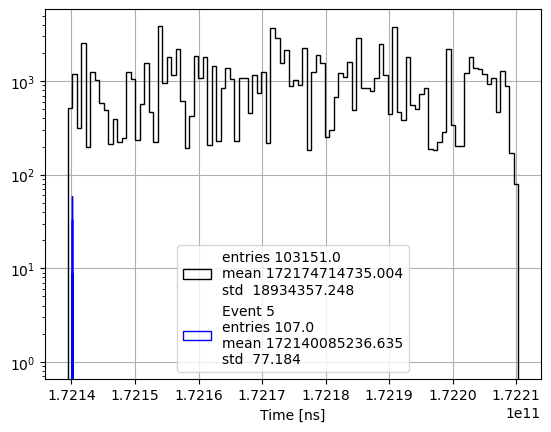

In [53]:
event = np.unique(df_triggered["evt"])[i]
pltext.hist(df_concat[df_concat["evt"].values == event]["time_corrected"], 100, ylog=True);
pltext.hist(df_triggered[df_triggered["evt"].values == event]["time_corrected"], 100, ylog=True, xylabels="Time [ns]", label=f"Event {event}");

In [ ]:
del unique_evts
del evt_starts
del times_array
gc.collect()